# PCam (PatchCamelyon dataset)
## Breast Cancer Detection using histopathological images 
### The system depicted the microscope-mounted digital cameras or scanners used to obtain histopathological images.

#### It’s a medical imaging dataset created from lymph node tissue slides.

#### The task is to detect whether metastatic cancer (tumor spread) is present in the tissue patch or not

#### Task specifically focused on detecting metastatic breast cancer in sentinel lymph node biopsies. 
#### When breast cancer spreads, the first place it usually goes is the sentinel lymph nodes (in the armpit area). Pathologists examine lymph node sections under the microscope to check for metastatic tumor tissue.

# Configurations

In [2]:
import warnings 
warnings.filterwarnings('ignore')

import os
import cv2

import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
class CFG:
    IMG_SIZE = 224
    BATCH_SIZE = 64
    EPOCHS = 1000
    LEARNING_RATE = 1e-4
    SEED = 42
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # use "cpu" if no GPU


In [4]:
# Set seed
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(CFG.SEED)

In [5]:
# Paths 
DATA_DIR = "/kaggle/input/histopathologic-cancer-detection"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
LABELS = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

In [6]:
# cancer_samples = LABELS[LABELS['label'] == 1].sample(10000, random_state=42)
# normal_samples = LABELS[LABELS['label'] == 0].sample(10000, random_state=42)

# LABELS = pd.concat([cancer_samples, normal_samples]).reset_index(drop=True)

### 0 = No metastasis (normal tissue)

### 1 = Metastasis present (Cancer tissue)

In [7]:
LABELS['label'].value_counts()[0], LABELS['label'].value_counts()[1] 

(130908, 89117)

In [8]:
print(f"Number of Normal Tissue samples : {LABELS[LABELS.label == 0].shape[0]}")
print(f"Number of Cancer Tissue samples : {LABELS[LABELS.label == 1].shape[0]}")

Number of Normal Tissue samples : 130908
Number of Cancer Tissue samples : 89117


# Data Visualization

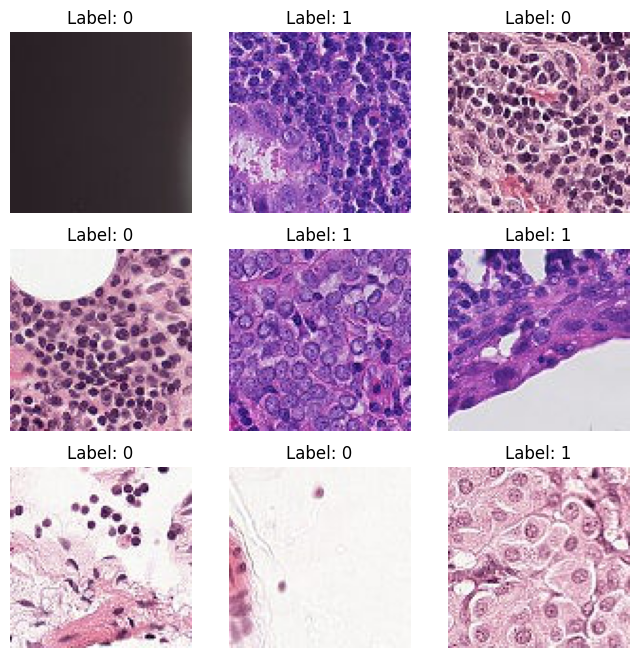

In [9]:
def show_samples(df, n=9):
    samples = df.sample(n)
    plt.figure(figsize=(8, 8))
    for i, (idx, row) in enumerate(samples.iterrows()):
        path = os.path.join(TRAIN_DIR, f"{row['id']}.tif")
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {row['label']}")
        plt.axis("off")
    plt.show()

show_samples(LABELS)

# Augmentations

In [10]:
train_transforms = A.Compose([
    A.RandomResizedCrop(size=(CFG.IMG_SIZE, CFG.IMG_SIZE), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    A.Resize(height=CFG.IMG_SIZE, width=CFG.IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Dataset class

In [11]:
class CancerDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['id']}.tif")
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = row['label']
        
        if self.transform:
            image = self.transform(image=image)["image"]
        
        return image, torch.tensor(label, dtype=torch.float32)

In [12]:
train_df, valid_df = train_test_split(LABELS, test_size=0.2, stratify=LABELS['label'], random_state=CFG.SEED)

train_dataset = CancerDataset(train_df, TRAIN_DIR, transform=train_transforms)
valid_dataset = CancerDataset(valid_df, TRAIN_DIR, transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=2)


# Model architecture

In [13]:
class CancerClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = models.resnet50(pretrained=pretrained)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, 1)
    
    def forward(self, x):
        return self.backbone(x).squeeze(1)

model = CancerClassifier().to(CFG.DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


# Loss & Optimizer

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)

# Model Training Function 

In [15]:
def train_one_epoch(loader, model, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total

# Model Evaluation Function

In [16]:
def validate(loader, model, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.int()).sum().item()
            total += labels.size(0)
    
    return total_loss / total, correct / total

# Training & Eval

In [17]:
%%time 
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in tqdm(range(CFG.EPOCHS)):
    train_loss, train_acc = train_one_epoch(train_loader, model, optimizer, criterion)
    val_loss, val_acc = validate(valid_loader, model, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if epoch%100 == 0:
        print(f"Epoch {epoch+1}/{CFG.EPOCHS} - "
           f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
           f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


  0%|          | 1/1000 [22:01<366:39:06, 1321.27s/it]

Epoch 1/1000 - Train Loss: 0.1738, Train Acc: 0.9341 | Val Loss: 0.1127, Val Acc: 0.9602


  3%|▎         | 29/1000 [8:04:41<270:28:36, 1002.80s/it]


KeyboardInterrupt: 

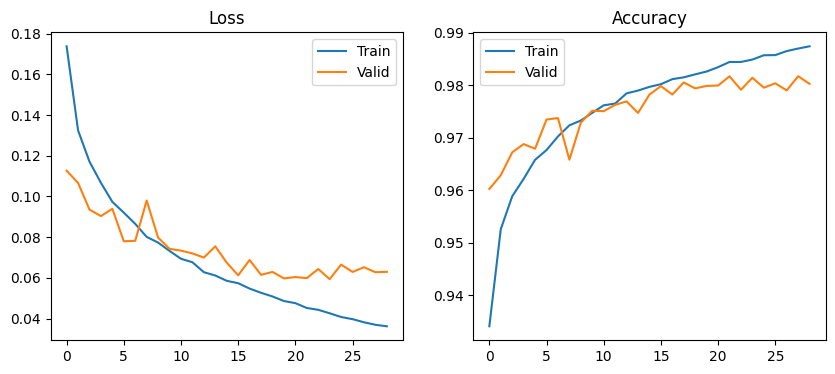

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Valid")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Valid")
plt.title("Accuracy")
plt.legend()
plt.show()

In [24]:
torch.save(model.state_dict(), "cancer_detector.pth")

# Inference
import matplotlib.pyplot as plt

# Inference with image display
def predict_single(img_path, model, transform):
    model.eval()
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = transform(image=image)["image"].unsqueeze(0).to(CFG.DEVICE)

    with torch.no_grad():
        output = model(image_tensor)
        prob = torch.sigmoid(output).item()
        pred_class = int(prob > 0.5)

    # Display the image with prediction info
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Pred: {'Cancer' if pred_class == 1 else 'Normal'} | Prob: {prob:.4f}")
    plt.show()

    return prob, pred_class

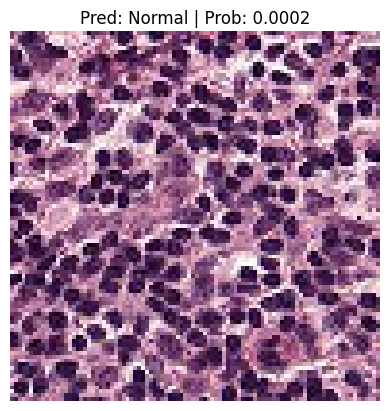

Prediction: 0, Probability: 0.0002
Actual: 0


In [25]:
# Pick an image
row = valid_df.iloc[1]  # take 2nd row
test_path = os.path.join(TRAIN_DIR, f"{row['id']}.tif")

# Run inference
prob, pred = predict_single(test_path, model, valid_transforms)

# Print results
print(f"Prediction: {pred}, Probability: {prob:.4f}")
print(f"Actual: {row['label']}")

just experiments 

In [21]:
# def validate(loader, model, criterion):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total = 0

#     all_labels = []
#     all_probs = []

#     with torch.no_grad():
#         for images, labels in loader:
#             images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
#             outputs = model(images)

#             # loss
#             loss = criterion(outputs, labels)
#             total_loss += loss.item() * images.size(0)

#             # probabilities
#             probs = torch.sigmoid(outputs).squeeze()
#             preds = (probs > 0.5).long()

#             # accuracy
#             correct += (preds == labels.long()).sum().item()
#             total += labels.size(0)

#             # collect for AUC
#             all_labels.extend(labels.cpu().numpy())
#             all_probs.extend(probs.cpu().numpy())

#     avg_loss = total_loss / total
#     accuracy = correct / total

#     # ROC-AUC
#     try:
#         auc = roc_auc_score(all_labels, all_probs)
#     except ValueError:
#         auc = float("nan")

#     return avg_loss, accuracy, auc, all_labels, all_probs

In [22]:
# # After training, run validation once
# val_loss, val_acc, val_auc, all_labels, all_probs = validate(val_loader, model, criterion)

# print(f"Validation Loss: {val_loss:.4f}")
# print(f"Validation Accuracy: {val_acc:.4f}")
# print(f"Validation AUC: {val_auc:.4f}")

# # Plot ROC Curve
# fpr, tpr, _ = roc_curve(all_labels, all_probs)
# plt.figure(figsize=(6, 6))
# plt.plot(fpr, tpr, label=f"AUC = {val_auc:.4f}")
# plt.plot([0, 1], [0, 1], "k--")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend(loc="lower right")
# plt.show()